In [1]:
import os
import sqlite3
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import rcParams
from matplotlib import pyplot as plt
import statsmodels.api as sm

%load_ext autoreload
%autoreload 2

### Question - 1
Using SQL language write a query that returns the 10 topmost profitable products by Animal,
Category_type and Age of Customers

In [2]:
cnx = sqlite3.connect(os.path.join('data', 'fressnapf.db'))
crsr = cnx.cursor()

In [3]:
sql_command = """
SELECT 
       cust.Age, 
       profit_table.animal,
       profit_table.cat_type,
       SUM (profit_table.total_transaction) AS grouped_transaction
       
FROM Customers cust
INNER JOIN
(SELECT pur.Customer_ID,
        pur.Product_ID,
        prod.Animal AS animal, 
        prod.Category_type AS cat_type,
        prod.Unit_Cost,
        pur.Quantity,
        pur.Quantity * prod.Unit_Cost AS total_transaction
         
FROM Purchase pur
INNER JOIN Products prod
ON (pur.Product_ID = prod.Product_ID) 
) AS profit_table
ON (cust.Customer_ID = profit_table.Customer_ID)

GROUP BY profit_table.animal, profit_table.cat_type, cust.Age
ORDER BY grouped_transaction DESC
LIMIT 10
"""
crsr.execute(sql_command)
ans_output = crsr.fetchall()

column_names = ["Animal", "Category_type", "Age of Customers", "Grouped_transaction"]
ans_output_df = pd.DataFrame(ans_output, columns=[column_names[2],
                                                  column_names[0], 
                                                  column_names[1],
                                                  column_names[3]])
ans_output_df = ans_output_df.reindex(columns=column_names)

In [4]:
ans_output_df

,Animal,Category_type,Age of Customers,Grouped_transaction
0,dogs,food,65,638223.88
1,dogs,food,42,522515.50
2,dogs,food,44,519736.03
3,dogs,food,43,516294.99
4,dogs,food,46,513155.57
5,dogs,food,41,505727.84
6,dogs,food,45,504036.62
7,dogs,food,40,503764.04
8,cats,food,65,493264.91
9,dogs,food,38,490517.48


<AxesSubplot:xlabel='Age of Customers', ylabel='Grouped_transaction'>

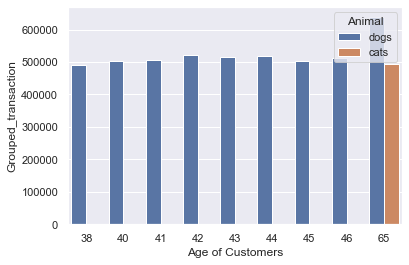

In [5]:
sns.set(rc={'figure.figsize':(17,7)})
sns.barplot(x="Age of Customers", y="Grouped_transaction", hue='Animal', 
                       data=ans_output_df)

### Question 2

In [6]:
df_customers = pd.read_sql_query("SELECT * FROM Customers", cnx)
df_Purchase = pd.read_sql_query("SELECT * FROM Purchase", cnx)
df_Products = pd.read_sql_query("SELECT * FROM Products", cnx)

In [7]:
products_purchase = pd.merge(df_Products, df_Purchase, on='Product_ID')

In [8]:
customer_purchase = pd.merge(df_customers, df_Purchase, on='Customer_ID')

In [9]:
customer_purchase_products = pd.merge(customer_purchase, df_Products, on='Product_ID')

#### Question 2.1
What is the most profitable product? And which one is the most frequent?

In [10]:
freq_profit_product = products_purchase.copy()
freq_profit_product = freq_profit_product[['Product_ID', 'Unit_Cost', 'Quantity']]

freq_profit_product['total_transaction'] =  \
    freq_profit_product['Unit_Cost'] * freq_profit_product['Quantity']

freq_profit_product = freq_profit_product.drop(columns=['Unit_Cost', 'Quantity'])

In [11]:
freq_profit_product = freq_profit_product.groupby('Product_ID')\
                                         .agg(frquency_product_id=('Product_ID', 'count'), 
                                              sales_product_id=('total_transaction', 'sum'))\
                                         .reset_index()
freq_profit_product = freq_profit_product.sort_values(['sales_product_id', 
                                                       'frquency_product_id'],
                                                       ascending=[False, False])
freq_profit_product.head()

,Product_ID,frquency_product_id,sales_product_id
3519,3619,237,43907.50
3272,3372,239,43362.20
4368,4468,235,40484.82
2906,3006,225,38862.74
4798,4898,226,38080.88


<AxesSubplot:xlabel='frquency_product_id', ylabel='sales_product_id'>

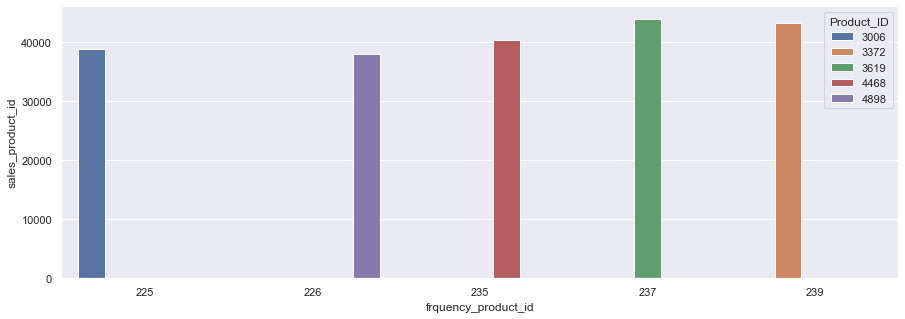

In [12]:
sns.set(rc={'figure.figsize':(15,5)})
sns.barplot(x="frquency_product_id", y="sales_product_id", hue='Product_ID', 
                       data=freq_profit_product.head())

#### Question 2.2
Which pet is more common among our customers?

In [13]:
customer_pet = products_purchase.copy()
customer_pet = customer_pet[['Animal', 'Customer_ID']]
customer_pet = customer_pet.drop_duplicates(keep='first')

common_index = 5
customer_pet = customer_pet.groupby('Animal')\
                           .agg(common_pet=('Customer_ID', 'count'))\
                           .sort_values('common_pet', ascending=False ).reset_index()\
                           .head(common_index)
customer_pet

,Animal,common_pet
0,dogs,98813
1,cats,96519
2,birds,80226
3,rodens,64581
4,others,40312


<AxesSubplot:xlabel='Animal', ylabel='common_pet'>

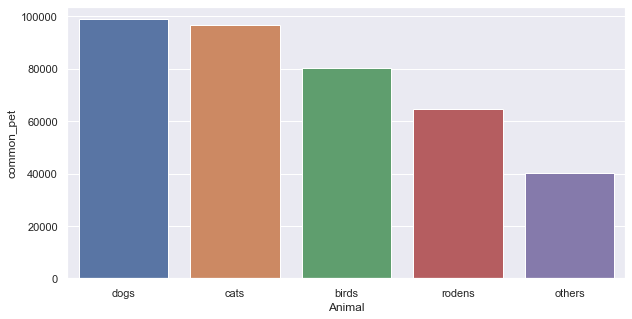

In [14]:
sns.set(rc={'figure.figsize':(10,5)})
sns.barplot(x="Animal", y="common_pet", data=customer_pet)

#### Question - 2.3
Which customer segment brings more revenue?

##### Steps:
1. Plot the age distribution of the customers
2. Choose appropriate bin size for age based on the distribution to nearly achieve balanced dataset
3. Compute the sales based on the artificially created customer segments 

In [15]:
unique_cust_age = customer_purchase.copy()
unique_cust_age = customer_purchase[['Customer_ID', 'Age']].\
                  drop_duplicates(keep='first')

c:\Users\Shrikanth Singh\anaconda3\envs\fressnapf_task\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Age', ylabel='Density'>

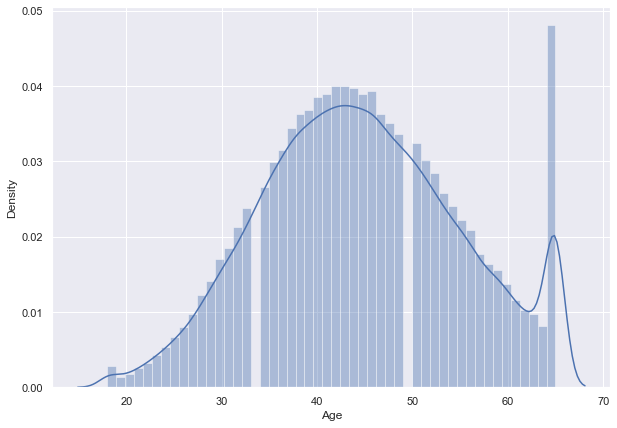

In [16]:
sns.set(rc={'figure.figsize':(10,7)})
sns.distplot(unique_cust_age['Age'])

In [17]:
def segment_data(age_input):
    """
    Creating segments of the dataset based on their age
    Args:
        age_input (int): Customers age
    Return:
        result_df (pd:Dataframe): Segmented dataset
    """
    if age_input <= 35:
        return 'Class_A'
    if age_input > 35 and age_input <= 40:
        return 'Class_B'
    if age_input > 40 and age_input <= 45:
        return 'Class_C'
    if age_input > 45 and age_input <= 50:
        return 'Class_D'
    if age_input > 50 and age_input <= 55:
        return 'Class_E'
    if age_input > 55:
        return 'Class_F'

In [18]:
customer_segment_df = customer_purchase_products.copy()
customer_segment_df['Customer_category'] = customer_segment_df['Age'].apply(lambda x: segment_data(x))

In [19]:
# Exporting data for task 3 - Develop a model for Customer Segmentation
customer_segment_df.to_csv(os.path.join('data', 'customer_segmentation_data.csv'))

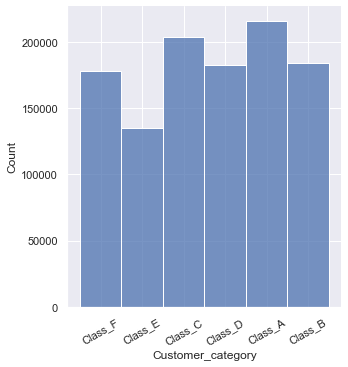

In [20]:
#sns.set(rc={'figure.figsize':(15,15)})
chart = sns.displot(customer_segment_df['Customer_category'])
chart.set_xticklabels(rotation=30)

In [21]:
customer_segment_df['Total_transaction'] = customer_segment_df['Quantity'] * customer_segment_df['Unit_Cost']

In [22]:
grouped_customer_segment = customer_segment_df.groupby(['Customer_category', 'Sex'])\
                                              .agg(Revenue_per_category=('Total_transaction', 'sum'))
grouped_customer_segment

Revenue_per_category
Customer_category Sex                         
Class_A           Female           10446508.45
                  Male              6169200.88
Class_B           Female            8959209.08
                  Male              5196061.68
Class_C           Female            9871959.06
                  Male              5776664.27
Class_D           Female            8817904.03
                  Male              5215025.78
Class_E           Female            6600801.81
                  Male              3802696.10
Class_F           Female            8677601.89
                  Male              5004932.10

Text(0.5, 1.0, 'Revenue based on Age class and Sex')

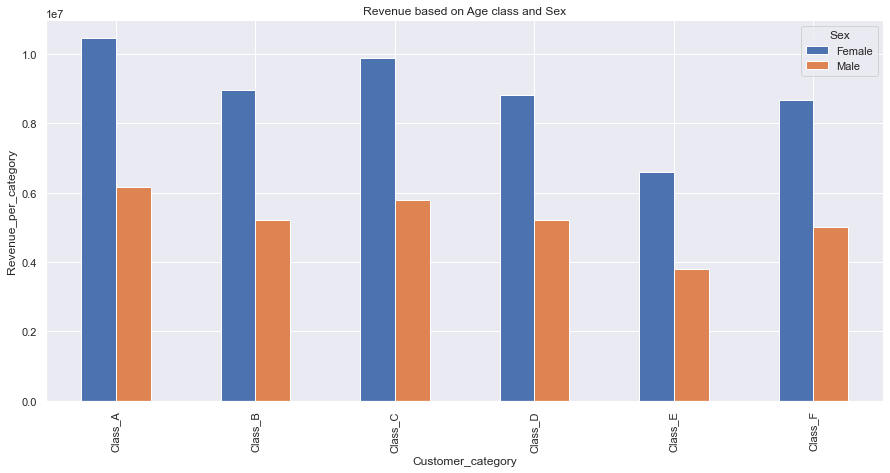

In [23]:
sns.set(rc={'figure.figsize':(15,7)})
grouped_customer_segment.unstack(level=1)['Revenue_per_category'].plot(kind='bar')
plt.ylabel('Revenue_per_category')
plt.title('Revenue based on Age class and Sex')

### Question - 2.4
Is there any trend in the data? What is the most profitable month?

In [24]:
trend_determination = customer_segment_df[['Customer_ID', 'Purchase_Date', 
                                           'Product_ID', 'Total_transaction']].copy()
trend_determination.head()

,Customer_ID,Purchase_Date,Product_ID,Total_transaction
0,1608647542,2019-04-14 00:00:00,3394,28.24
1,4476271,2020-08-08 00:00:00,3394,28.24
2,890045971,2020-09-14 00:00:00,3394,42.36
3,778400091,2020-02-15 00:00:00,3394,42.36
4,143942619,2020-11-18 00:00:00,3394,42.36


In [25]:
def grouped(df, key, freq, col):
    df_grouped = df.groupby([pd.Grouper(key=key, freq=freq)]).agg(mean = (col, 'mean'))
    df_grouped = df_grouped.reset_index()
    return df_grouped

def add_time(df, key, freq, col):
    df_grouped = grouped(df, key, freq, col)
    df_grouped['time'] = np.arange(len(df_grouped.index))
    column_time = df_grouped.pop('time')
    df_grouped.insert(1, 'time', column_time)
    return df_grouped

def sales_behaviour_plot(input_data):
    
    input_data['Purchase_Date'] = pd.to_datetime(input_data['Purchase_Date'])

    input_data_grouped_w = add_time(input_data, 'Purchase_Date', 'W', 'Total_transaction')
    fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(35,30))

    # Sales (Weekly)
    axes[0].plot('time', 'mean', data=input_data_grouped_w, color='0.75')
    axes[0].set_title("Sales grouped by week", fontsize=20)
    axes[0] = sns.regplot(x='time', 
                    y='mean', 
                    data=input_data_grouped_w,
                    order=1, 
                    scatter_kws=dict(color='0.15'), 
                    ax = axes[0])

    input_data_grouped_m = add_time(input_data, 'Purchase_Date', 'M', 'Total_transaction')
    # Sales (Montly)
    axes[1].plot('time', 'mean', data=input_data_grouped_m, color='0.75')
    axes[1].set_title("Sales grouped by month", fontsize=20)
    axes[1] = sns.regplot(x='time', 
                    y='mean', 
                    data=input_data_grouped_m, 
                    order=1,
                    scatter_kws=dict(color='0.15'), 
                    ax = axes[1])

    input_data_grouped_q = add_time(input_data, 'Purchase_Date', '3M', 'Total_transaction')
    # Sales (Quarterly)
    axes[2].plot('time', 'mean', data=input_data_grouped_q, color='0.75')
    axes[2].set_title("Sales grouped by Quartely", fontsize=20)
    axes[2] = sns.regplot(x='time', 
                    y='mean', 
                    data=input_data_grouped_q,
                    order=1, 
                    scatter_kws=dict(color='0.15'), 
                    ax = axes[2])

    input_data_grouped_h = add_time(input_data, 'Purchase_Date', '6M', 'Total_transaction')
    # Sales (Halferly)
    axes[3].plot('time', 'mean', data=input_data_grouped_h, color='0.75')
    axes[3].set_title("Sales grouped by Halferly", fontsize=20)
    axes[3] = sns.regplot(x='time', 
                    y='mean', 
                    data=input_data_grouped_h,
                    order=1, 
                    scatter_kws=dict(color='0.15'), 
                    ax = axes[3])

    input_data_grouped_h = add_time(input_data, 'Purchase_Date', '12M', 'Total_transaction')
    # Sales (Yearly)
    axes[4].plot('time', 'mean', data=input_data_grouped_h, color='0.75')
    axes[4].set_title("Sales grouped by Yearly", fontsize=20)
    axes[4] = sns.regplot(x='time', 
                    y='mean', 
                    data=input_data_grouped_h,
                    order=1, 
                    scatter_kws=dict(color='0.15'), 
                    ax = axes[4])

In [26]:
trend_determination_gby_date = trend_determination.groupby(['Purchase_Date'])\
                                                  .agg({'Total_transaction': "sum"}).reset_index()

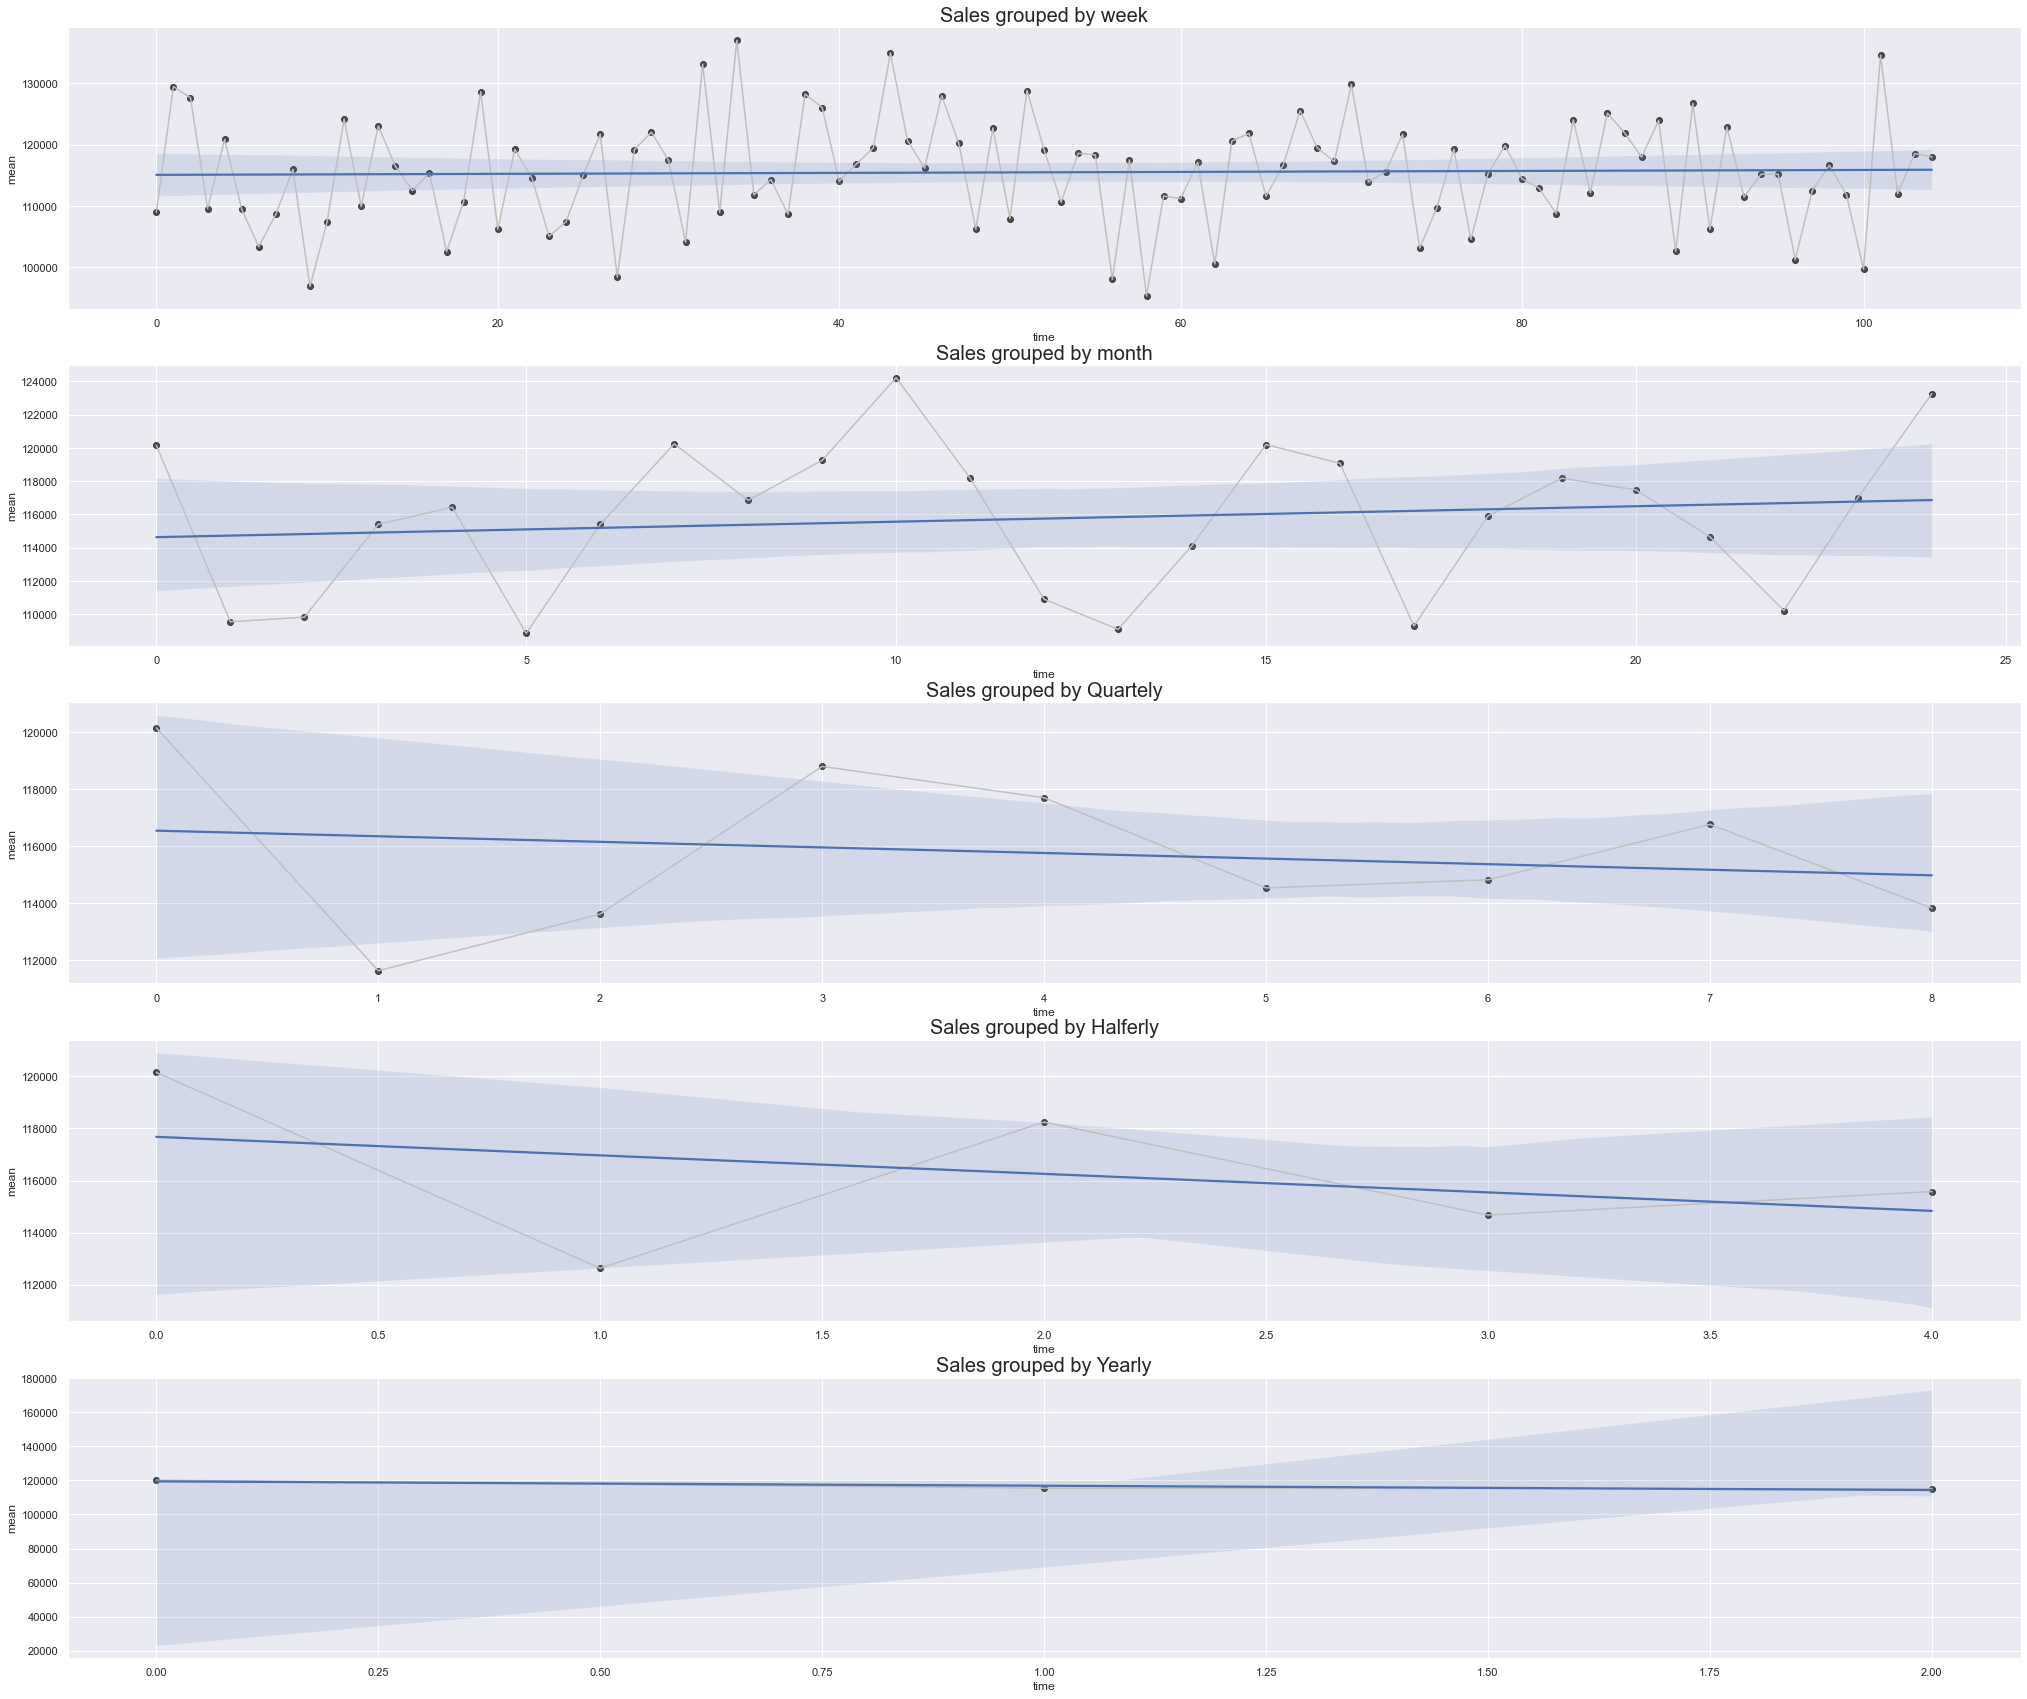

In [27]:
sales_behaviour_plot(trend_determination_gby_date)

In [28]:
time_decompose = trend_determination_gby_date.copy()
time_decompose = time_decompose.set_index('Purchase_Date')
decomposition = sm.tsa.seasonal_decompose(time_decompose)
rcParams["figure.figsize"] = 30, 4

<AxesSubplot:xlabel='Purchase_Date'>

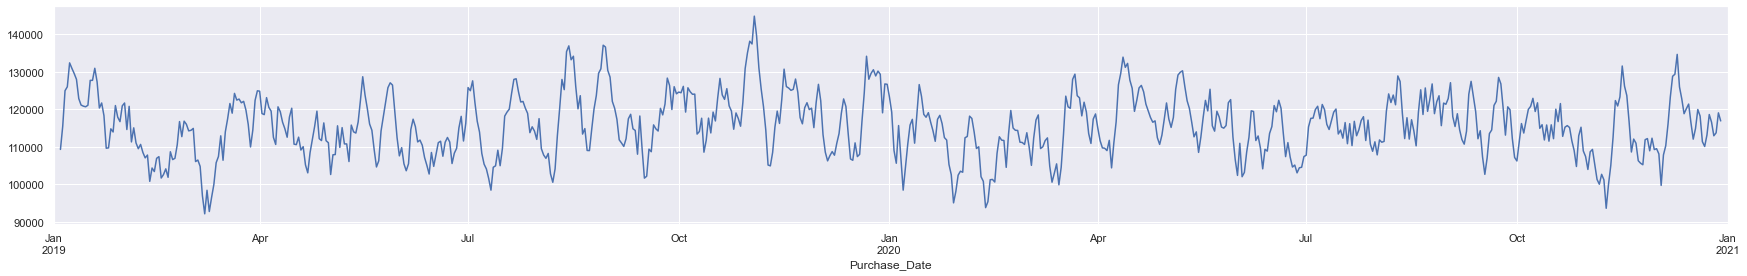

In [29]:
decomposition.trend.plot()

<AxesSubplot:xlabel='Purchase_Date'>

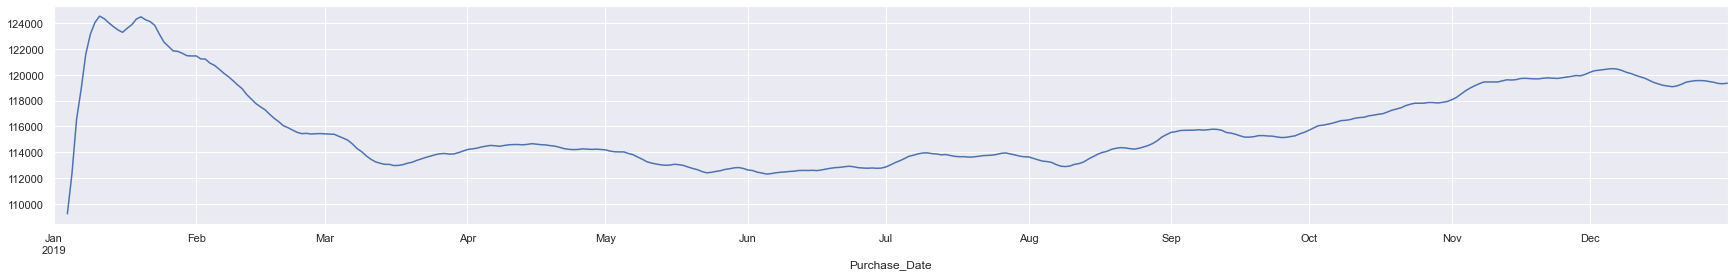

In [30]:
decomposition.trend['2019'].rolling('120D').mean().plot()

<AxesSubplot:xlabel='Purchase_Date'>

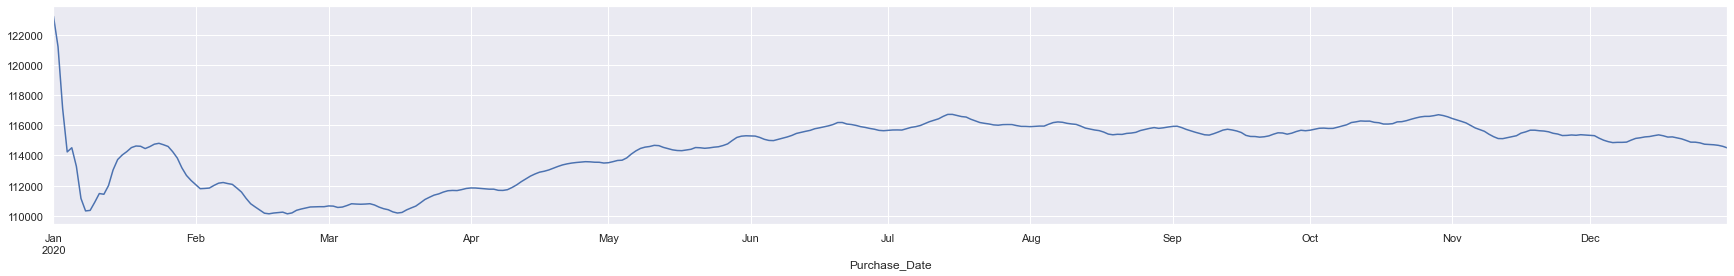

In [31]:
decomposition.trend['2020'].rolling('120D').mean().plot()

<AxesSubplot:xlabel='Purchase_Date'>

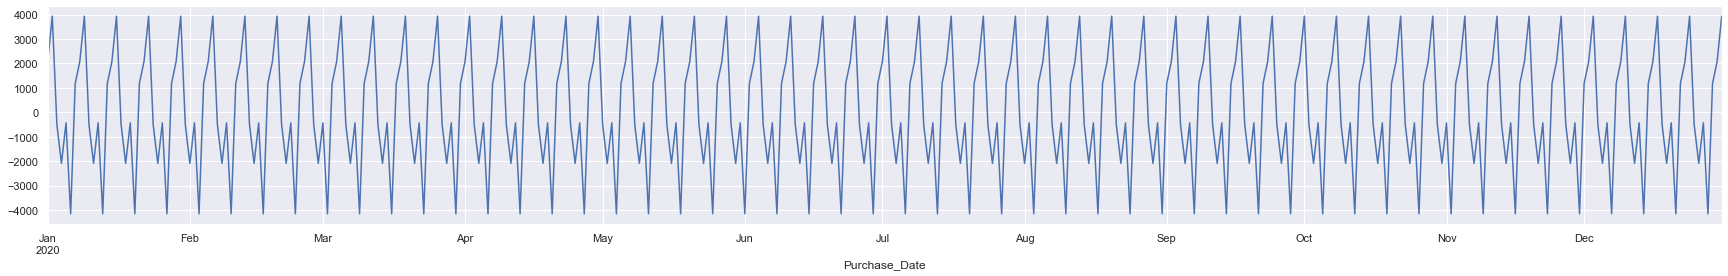

In [32]:
decomposition.seasonal['2020'].plot()

### Question 2.5
What is the customer churn rate 

* Churn Rate - Expressed as percentage of customers stopped purchasing from Fressnapf after a specific time period.

* Churn rate = (number of lost customers / total amount of customers) * 100

* For example if fressnapf loses 10 customers from a 1500 customer base, the churn rate would be (10/1500)*100 =  66%

A primitive implementation of the above explanation is shown below on an yearly basic, simply plug in the value for the year and the window size in days to be considered as the customer churn. 

* Monthly churn rate can also be calculated by forming a centered matrix as shown below
![](./images/2022-06-04-20-48-51.png)



In [33]:
churn_rate_calculation = customer_purchase.copy()
churn_rate_calculation['Purchase_Date'] = pd.to_datetime(churn_rate_calculation['Purchase_Date'], dayfirst=True)

In [34]:
def churn_rate(year, churn_window):

    truncated_data = churn_rate_calculation[churn_rate_calculation['Purchase_Date'].dt.year == year]
    last_transaction = truncated_data.groupby('Customer_ID')['Purchase_Date'].max().reset_index()

    last_day_year = pd.to_datetime(f'{year}-12-31')
    last_transaction['last_purchase'] = last_day_year - last_transaction['Purchase_Date']
    last_transaction['last_purchase'] = last_transaction['last_purchase'].apply(lambda x: x.days)

    last_transaction.loc[last_transaction['last_purchase'] > churn_window,'Category']='Churned'
    last_transaction.loc[last_transaction['last_purchase'] <= churn_window,'Category']='Survived'

    churn_rate = round((len(last_transaction[last_transaction['Category'] == 'Churned']) \
                        / len(last_transaction) * 100), 
                        2)
    
    return last_transaction, churn_rate

In [35]:
year, window = 2020, 90
churn_rate_result, churn_ratio = churn_rate(year, window)
print(f'Churn rate of customers for the year {year} with a window of {window} days = {churn_ratio}')
churn_rate_result.sample(frac=1).head()

Churn rate of customers for the year 2020 with a window of 90 days = 25.49


,Customer_ID,Purchase_Date,last_purchase,Category
18330,369448218,2020-06-21,193,Churned
74665,1506738950,2020-12-31,0,Survived
47975,970163311,2020-03-01,305,Churned
77529,1565201207,2020-12-02,29,Survived
93466,1887643569,2020-12-23,8,Survived


In [36]:
year, window = 2019, 90
churn_rate_result, churn_ratio = churn_rate(year, window)
print(f'Churn rate of customers for the year {year} with a window of {window} days = {churn_ratio}')
churn_rate_result.sample(frac=1).head()

Churn rate of customers for the year 2019 with a window of 90 days = 23.47


,Customer_ID,Purchase_Date,last_purchase,Category
75455,1513058545,2019-12-29,2,Survived
75077,1505244642,2019-11-19,42,Survived
44178,886658271,2019-12-30,1,Survived
12412,248586879,2019-12-24,7,Survived
49882,1000952529,2019-11-23,38,Survived
